In [3]:
"""
for_notebook.py
----------------
This script contains a FULL end‑to‑end unsupervised Heston calibration
pipeline designed specifically for copying into a Jupyter Notebook.

It is organized into numbered segments corresponding exactly to notebook
cells:
    1. Imports
    2. Download S&P 500 data
    3. Compute returns and slice window
    4. Build option table from textbook data
    5. Construct OptionBatch
    6. Build latent-volatility model
    7. Heston parameters
    8. Optimizer
    9. Single training step
    10. Multi-epoch loop
    11. Plot training loss
    12. Plot variance path

You can copy/paste these blocks directly into a .ipynb file.
"""

# =======================
# 1. IMPORTS
# =======================

import torch
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

from vol_calib import (
    LatentVolatilityModel,
    HestonParams,
    JointHestonLoss,
    OptionBatch,
    example_training_step,
)

import cos_pricers  # Assumes your COS pricer file is available
from datetime import datetime


# =======================
# 2. DOWNLOAD S&P 500 DATA
# =======================

def load_sp500(start="2000-01-01", end="2002-04-18"):
    spx = yf.download("^GSPC", start=start, end=end, auto_adjust=True)
    spx["returns"] = np.log(spx["Close"] / spx["Close"].shift(1))
    spx = spx.dropna()
    return spx


# =======================
# 3. COMPUTE RETURNS & SLICE WINDOW
# =======================

def prepare_return_window(spx, T=252):
    x_returns = torch.tensor(spx["returns"].values[-T:], dtype=torch.float32)
    x = x_returns.unsqueeze(0).unsqueeze(-1)  # (1, T, 1)

    prices = torch.tensor(spx["Close"].values[-(T+1):], dtype=torch.float32)
    S_tensor = prices.unsqueeze(0)  # (1, T+1)

    S0 = float(prices[-1])
    return x, S_tensor, S0


# =======================
# 4. OPTION TABLE (FROM BOOK)
# =======================

def load_textbook_option_table():
    # TEMPLATE — USER FILLS VALUES
    option_table = pd.DataFrame({
        "Strike": [975, 995, 1025, 1050, 1075, 1090, 1100, 1110, 1120, 1125,
                    1130, 1135, 1140, 1150, 1160, 1170, 1175, 1200, 1225, 1250, 1275],

        # Fill these columns EXACTLY with data from your textbook table
        "May2002":  [161.60, 144.80, 120.10, 84.50, 64.30, 43.10, 35.60, 39.50,
                     22.90, 20.20, 28.00, 25.60, 13.30, 19.10, 15.30, 12.10,
                     10.90, None, None, None, None],

        "Jun2002":  [173.30, 157.00, 133.10, 100.70, 82.50, None, 65.50, None,
                     33.50, 30.70, None, 45.50, 23.20, 38.10, None, None, 27.70,
                     19.60, 13.20, None, 13.20],
    })

    option_table = option_table.dropna(how="all", axis=1)
    option_table = option_table.dropna(how="all", axis=0)
    return option_table


# =======================
# 5. BUILD OPTIONBATCH
# =======================

def build_option_batch(option_table, S0, maturity_col="Jun2002"):
    # Maturity for June 2002 options
    today = datetime(2002, 4, 18)
    expiry = datetime(2002, 6, 21)
    tau_years = (expiry - today).days / 365

    K = torch.tensor(option_table["Strike"].values, dtype=torch.float32).unsqueeze(0)
    price = torch.tensor(option_table[maturity_col].values,
                         dtype=torch.float32).unsqueeze(0)
    tau = torch.full_like(price, tau_years)

    return OptionBatch(
        S=torch.tensor([S0]),
        K=K,
        tau=tau,
        price=price,
        is_call=True,
    )


# =======================
# 6. BUILD LATENT MODEL
# =======================

def build_latent_model(T):
    return LatentVolatilityModel(
        input_dim=1,
        seq_len=T,
        tcn_channels=(32, 32, 64),
        latent_dim=32,
        decoder_hidden_dim=64,
        output_mode="logvar",
    )


# =======================
# 7. HESTON PARAMETERS
# =======================

def default_heston_params():
    return HestonParams(
        kappa=2.0,
        theta=0.04,
        sigma=0.5,
        rho=-0.7,
        v0=0.04,
        xi_s=0.0,
        xi_v=0.0,
    )


# =======================
# 8. OPTIMIZER
# =======================

def build_optimizer(model, lr=1e-3):
    return torch.optim.Adam(model.parameters(), lr=lr)


# =======================
# 9. RUN SINGLE TRAINING STEP
# =======================

def run_single_step(joint_model, optimizer, x, S_tensor, opt_batch):
    dt = 1/252
    batch = {"x": x, "S": S_tensor, "opt": opt_batch,
             "r": 0.019, "q": 0.012}
    return example_training_step(
        model=joint_model,
        optimizer=optimizer,
        batch=batch,
        dt=dt,
        cos_module=cos_pricers,
    )


# =======================
# 10. MULTI-EPOCH TRAINING LOOP
# =======================

def train_epochs(joint_model, optimizer, x, S_tensor, opt_batch,
                 epochs=300):
    history = []
    dt = 1/252

    for epoch in range(epochs):
        batch = {"x": x, "S": S_tensor, "opt": opt_batch,
                 "r": 0.019, "q": 0.012}
        metrics = example_training_step(
            model=joint_model,
            optimizer=optimizer,
            batch=batch,
            dt=dt,
            cos_module=cos_pricers,
        )
        history.append(metrics)
        if epoch % 20 == 0:
            print(f"Epoch {epoch}: {metrics}")

    return history


# =======================
# 11. PLOT TRAINING LOSS
# =======================

def plot_loss(history):
    losses = [h["loss"] for h in history]
    plt.plot(losses)
    plt.title("Training Loss")
    plt.show()


# =======================
# 12. PLOT VARIANCE PATH
# =======================

def plot_variance_path(latent_model, x):
    with torch.no_grad():
        v = latent_model(x)[0, :, 0].numpy()
    plt.plot(v)
    plt.title("Learned Latent Variance Path")
    plt.show()


# END OF FILE

In [4]:
spx = load_sp500()
spx.tail()

[*********************100%***********************]  1 of 1 completed

Price,Close,High,Low,Open,Volume,returns
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,
Date,,,,,,
2002-04-11,1103.689941,1130.469971,1102.420044,1130.469971,1505600000,-0.023974
2002-04-12,1111.010010,1112.770020,1102.739990,1103.689941,1282100000,0.006610
2002-04-15,1102.550049,1114.859985,1099.410034,1111.010010,1120400000,-0.007644
2002-04-16,1128.369995,1129.400024,1102.550049,1102.550049,1341300000,0.023148
2002-04-17,1126.069946,1133.000000,1123.369995,1128.369995,1376900000,-0.002040


In [5]:
T = 252  # or whatever you want
x, S_tensor, S0 = prepare_return_window(spx, T=T)
S0

1126.0699462890625

In [6]:
option_table = load_textbook_option_table()
option_table

,Strike,May2002,Jun2002
0,975,161.6,173.3
1,995,144.8,157.0
2,1025,120.1,133.1
3,1050,84.5,100.7
4,1075,64.3,82.5
5,1090,43.1,NaN
6,1100,35.6,65.5
7,1110,39.5,NaN
8,1120,22.9,33.5
9,1125,20.2,30.7


In [7]:
opt_batch = build_option_batch(option_table, S0=S0, maturity_col="Jun2002")
opt_batch

OptionBatch(S=tensor([1126.0699]), K=tensor([[ 975.,  995., 1025., 1050., 1075., 1090., 1100., 1110., 1120., 1125.,
         1130., 1135., 1140., 1150., 1160., 1170., 1175., 1200., 1225., 1250.,
         1275.]]), tau=tensor([[0.1753, 0.1753, 0.1753, 0.1753, 0.1753, 0.1753, 0.1753, 0.1753, 0.1753,
         0.1753, 0.1753, 0.1753, 0.1753, 0.1753, 0.1753, 0.1753, 0.1753, 0.1753,
         0.1753, 0.1753, 0.1753]]), price=tensor([[173.3000, 157.0000, 133.1000, 100.7000,  82.5000,      nan,  65.5000,
              nan,  33.5000,  30.7000,      nan,  45.5000,  23.2000,  38.1000,
              nan,      nan,  27.7000,  19.6000,  13.2000,      nan,  13.2000]]), is_call=True)

In [8]:
latent = build_latent_model(T)
latent

LatentVolatilityModel(
  (encoder): TCNEncoder(
    (tcn): Sequential(
      (0): TemporalBlock(
        (conv1): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(2,))
        (chomp1): Chomp1d()
        (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(2,))
        (chomp2): Chomp1d()
        (dropout): Dropout(p=0.1, inplace=False)
        (downsample): Conv1d(1, 32, kernel_size=(1,), stride=(1,))
        (activation): ReLU()
      )
      (1): TemporalBlock(
        (conv1): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(2,))
        (chomp1): Chomp1d()
        (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(2,))
        (chomp2): Chomp1d()
        (dropout): Dropout(p=0.1, inplace=False)
        (activation): ReLU()
      )
      (2): TemporalBlock(
        (conv1): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(4,))
        (chomp1): Chomp1d()
        (conv2): Conv1d(64, 64, kernel_size

In [9]:
params = default_heston_params()
joint_model = JointHestonLoss(latent, params)
optimizer = build_optimizer(joint_model)

In [10]:
metrics = run_single_step(joint_model, optimizer, x, S_tensor, opt_batch)
metrics

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [3]:
strat_train_set, strat_test_set = train_test_split(
    bank_df, test_size=0.2, stratify=bank_df["y"], random_state=42)

In [29]:
def proportions(data):
    return data["y"].value_counts() / len(data)

train_set, test_set = train_test_split(bank_df, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall %": proportions(bank_df),
    "Stratified %": proportions(strat_test_set),
    "Random %": proportions(test_set),
}).sort_index()

compare_props.index.name = "Target"
compare_props["Strat. Error %"] = (compare_props["Stratified %"] /
                                   compare_props["Overall %"] - 1)
compare_props["Rand. Error %"] = (compare_props["Random %"] /
                                  compare_props["Overall %"] - 1)
(compare_props * 100).round(2)

,Overall %,Stratified %,Random %,Strat. Error %,Rand. Error %
Target,,,,,
no,88.3,88.3,87.94,-0.00,-0.41
yes,11.7,11.7,12.06,0.01,3.13


## Explore Data to Gain Insights
We will make do an exploratory data analysis on the strat_train_set

We will make a copy of these and then use that for exploration

In [4]:
explore_df = strat_train_set.copy()

In [26]:
explore_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36168 entries, 24001 to 44229
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        36168 non-null  int64 
 1   job        36168 non-null  object
 2   marital    36168 non-null  object
 3   education  36168 non-null  object
 4   default    36168 non-null  object
 5   balance    36168 non-null  int64 
 6   housing    36168 non-null  object
 7   loan       36168 non-null  object
 8   contact    36168 non-null  object
 9   day        36168 non-null  int64 
 10  month      36168 non-null  object
 11  duration   36168 non-null  int64 
 12  campaign   36168 non-null  int64 
 13  pdays      36168 non-null  int64 
 14  previous   36168 non-null  int64 
 15  poutcome   36168 non-null  object
 16  y          36168 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.0+ MB


In [30]:
explore_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
24001,36,technician,divorced,secondary,no,861,no,no,telephone,29,aug,140,2,-1,0,unknown,no
43409,24,student,single,secondary,no,4126,no,no,cellular,5,apr,907,4,185,7,failure,yes
20669,44,technician,single,secondary,no,244,yes,no,cellular,12,aug,1735,4,-1,0,unknown,yes
18810,48,unemployed,married,secondary,no,0,no,no,telephone,31,jul,35,11,-1,0,unknown,no
23130,38,technician,married,secondary,no,257,no,no,cellular,26,aug,57,10,-1,0,unknown,no


In [5]:
explore_num = explore_df.select_dtypes(include=[np.number])
explore_cat = explore_df.select_dtypes(exclude=[np.number])

In [ ]:
explore_corr = explore_num.corr()
explore_corr

,age,balance,day,duration,campaign,pdays,previous
age,1.000000,0.096164,-0.009765,-0.004284,0.007818,-0.024410,0.001832
balance,0.096164,1.000000,0.002354,0.021114,-0.014405,0.003141,0.017328
day,-0.009765,0.002354,1.000000,-0.031352,0.161620,-0.093492,-0.049443
duration,-0.004284,0.021114,-0.031352,1.000000,-0.086704,-0.006306,-0.000790
campaign,0.007818,-0.014405,0.161620,-0.086704,1.000000,-0.088898,-0.031240
pdays,-0.024410,0.003141,-0.093492,-0.006306,-0.088898,1.000000,0.438963
previous,0.001832,0.017328,-0.049443,-0.000790,-0.031240,0.438963,1.000000


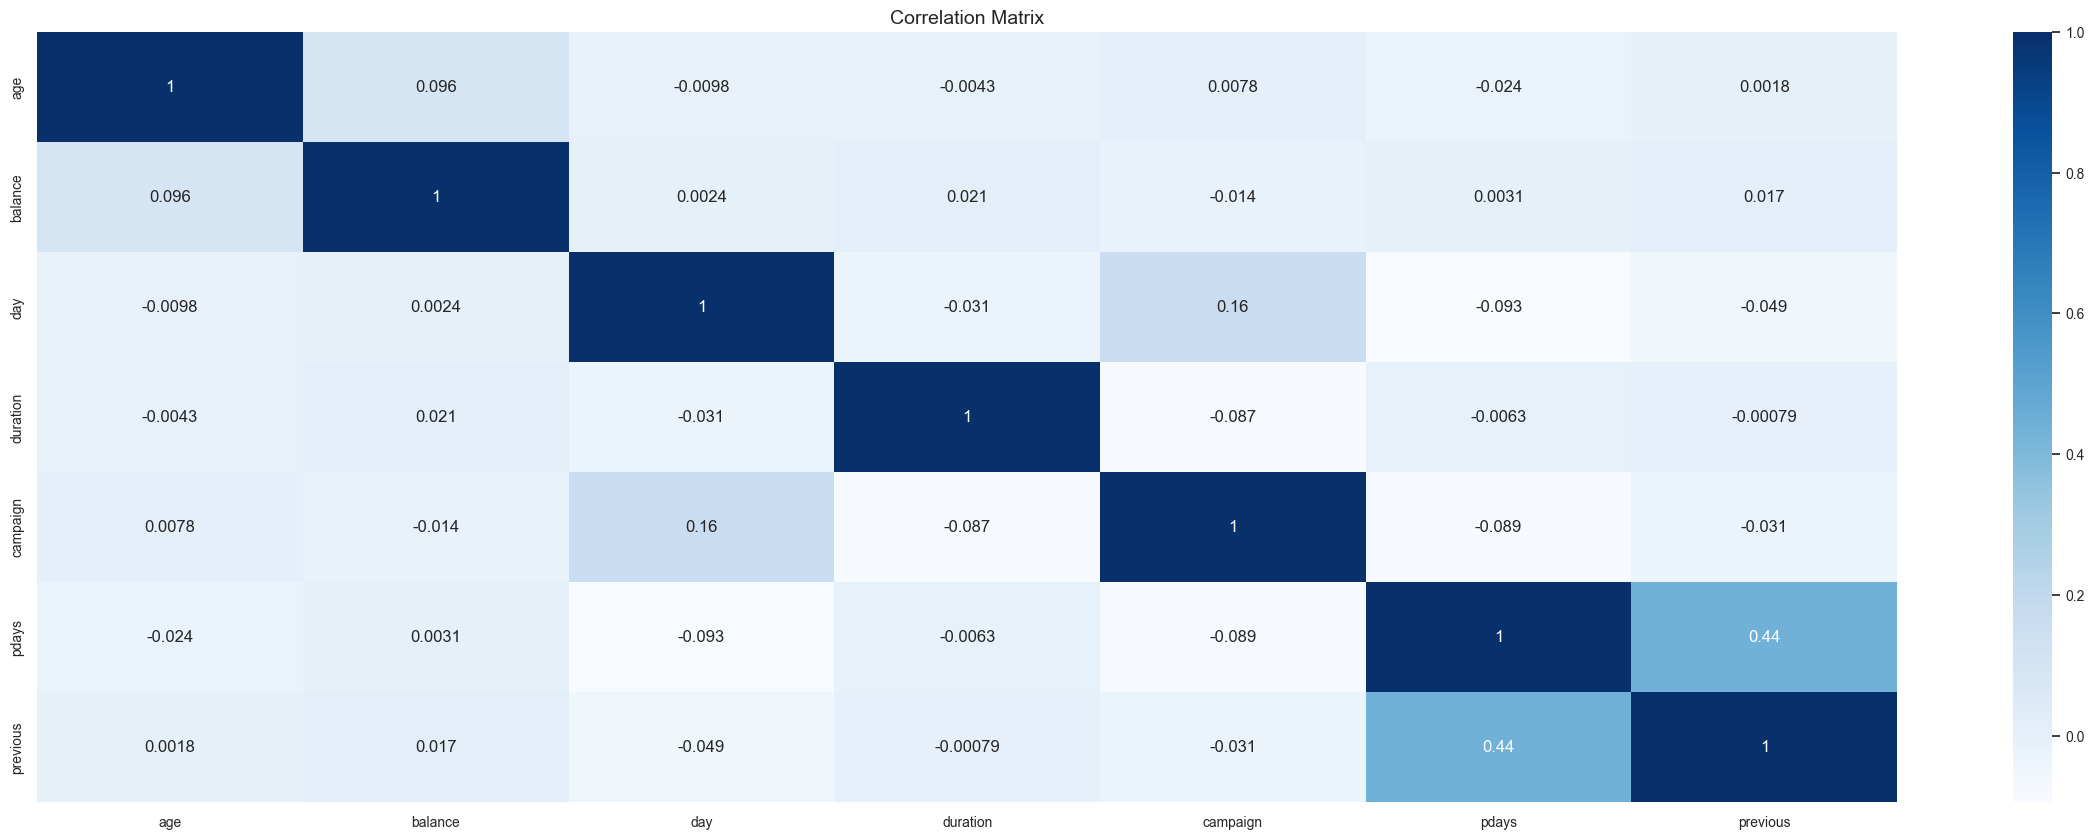

In [61]:
sns.heatmap(explore_corr, annot=True, cmap='Blues')
plt.title('Correlation Matrix')
plt.show()

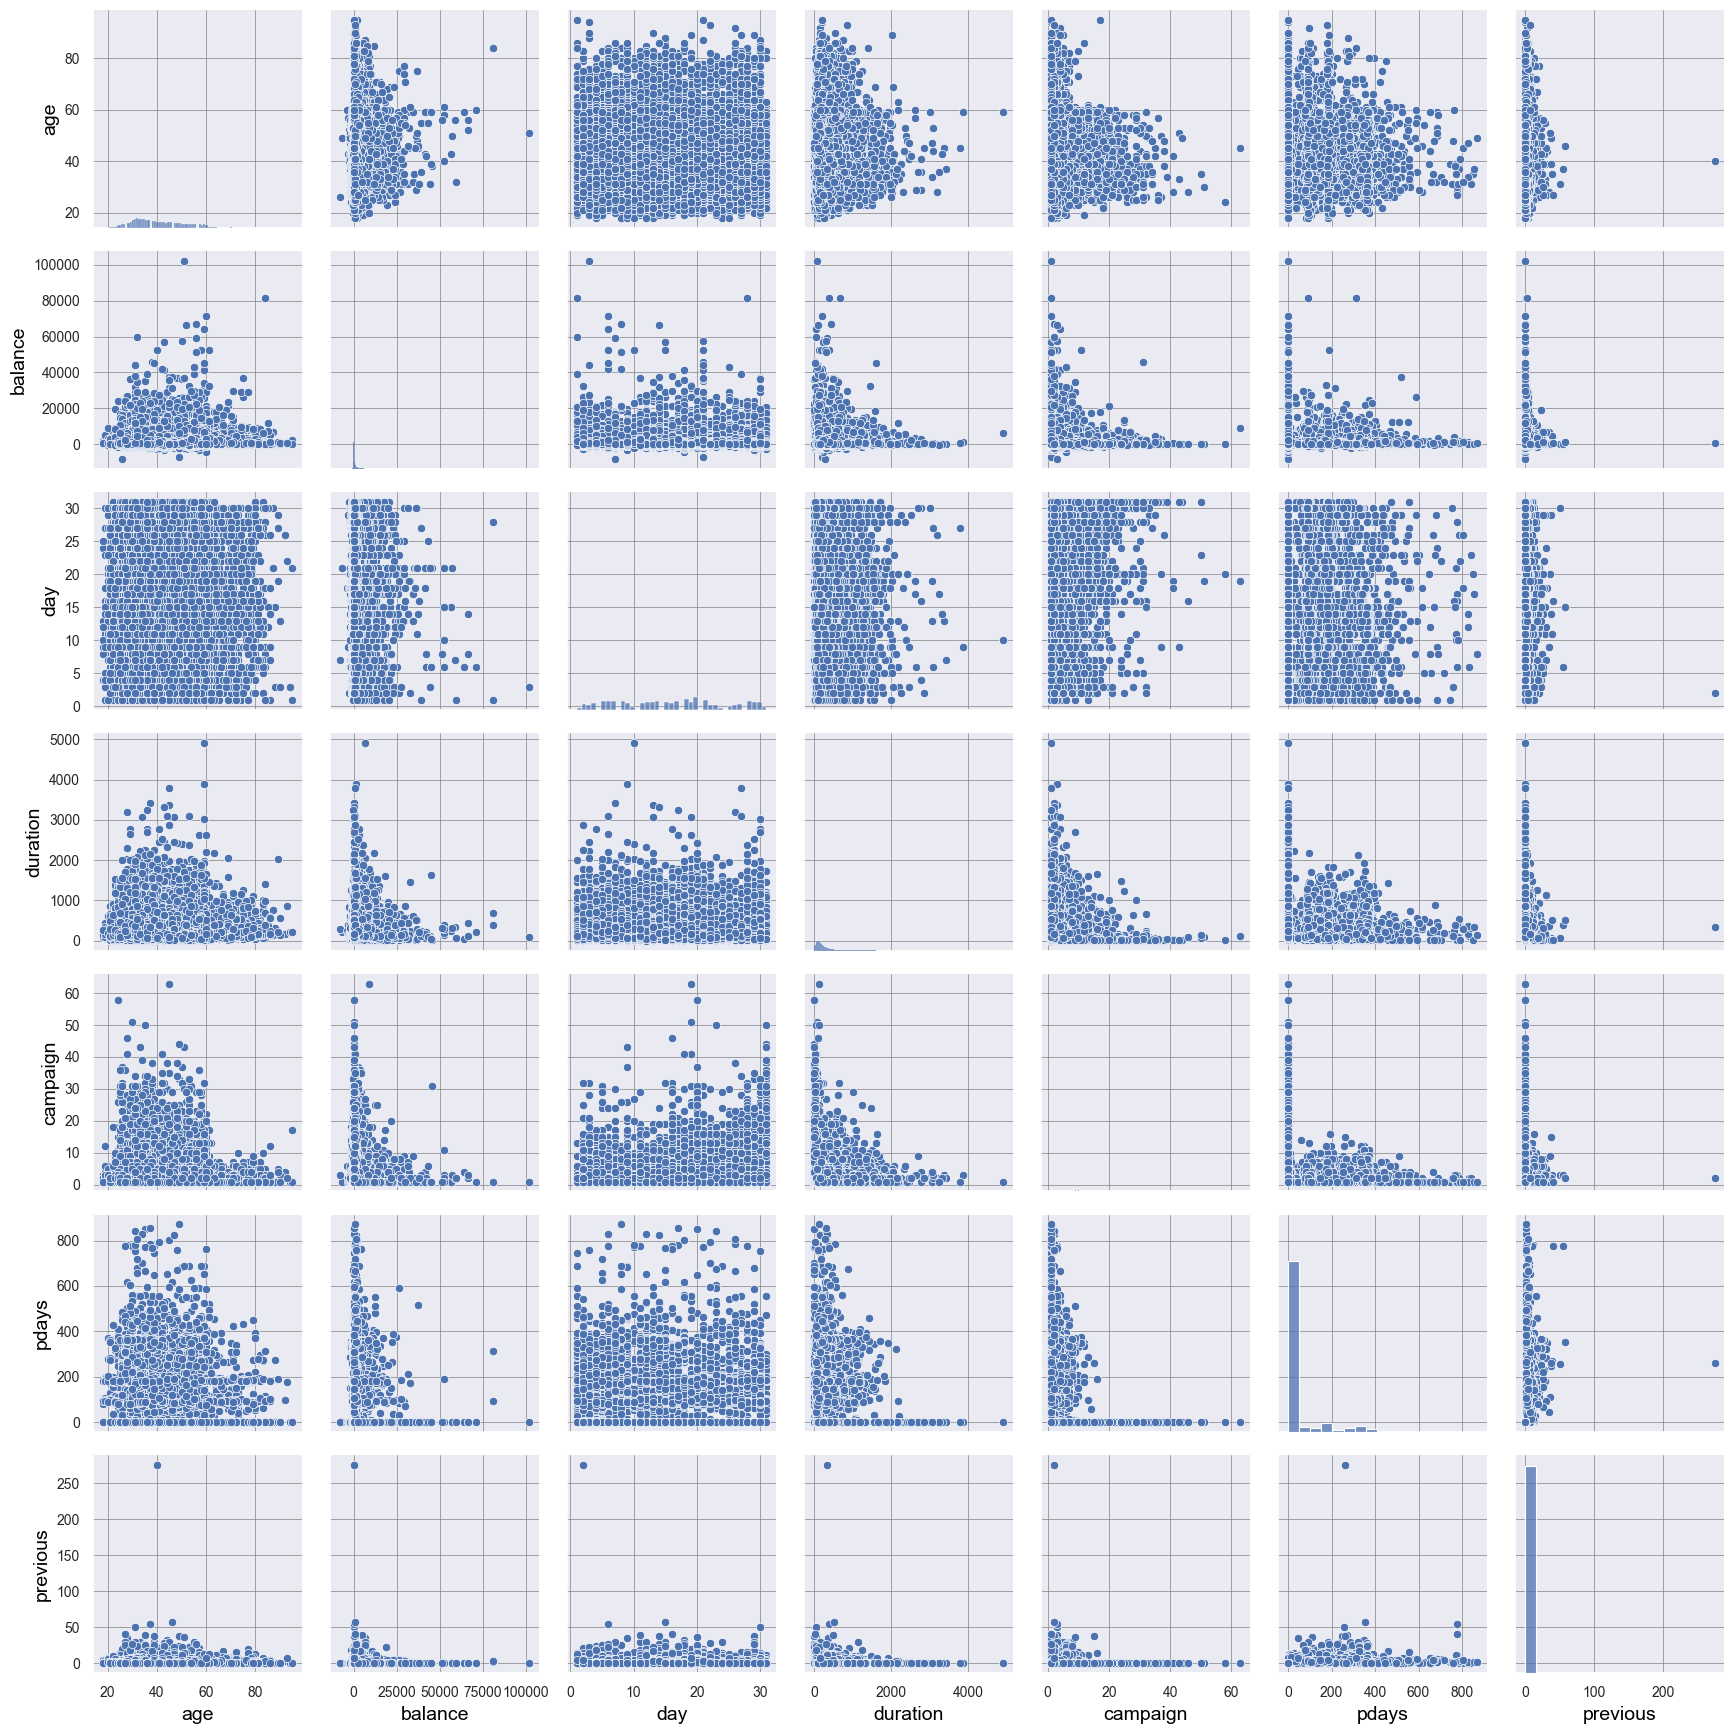

In [46]:
sns.pairplot(explore_num)
plt.tight_layout()
plt.show()

There is not a lot of correlation amongst the numeric values. This could suggest nonlinear relationships exist or they're
totally independent of each other, the latter which is good for some ML algos because then there's no redundancy

In [6]:
def size_up(df, pivot, kind, fig_rows=12, fig_cols=8):
  num_cols = len(df.columns)
  n_rows = int(np.ceil(num_cols / pivot))
  n_cols = min(num_cols, pivot)

  # Create subplots with the dynamic layout
  fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(fig_rows, fig_cols))

  # Flatten the axes array
  axes = axes.flatten()
  
  plots = {
    'box': sns.boxplot,
    'kde': sns.kdeplot,
    'dist': sns.distplot
  }

  # Iterate through the columns and create subplots
  for i, col in enumerate(df.columns):
      ax = axes[i]
      # ax.hist(df[col])
      
      plots.get(kind)(data=df[col], ax=ax)
      ax.set_title(col)

  # Remove any unused subplots
  for ax in axes:
    if not ax.has_data():
        fig.delaxes(ax)
        

  # Adjust the spacing between subplots
  plt.tight_layout()

  # Show the plot
  plt.show()

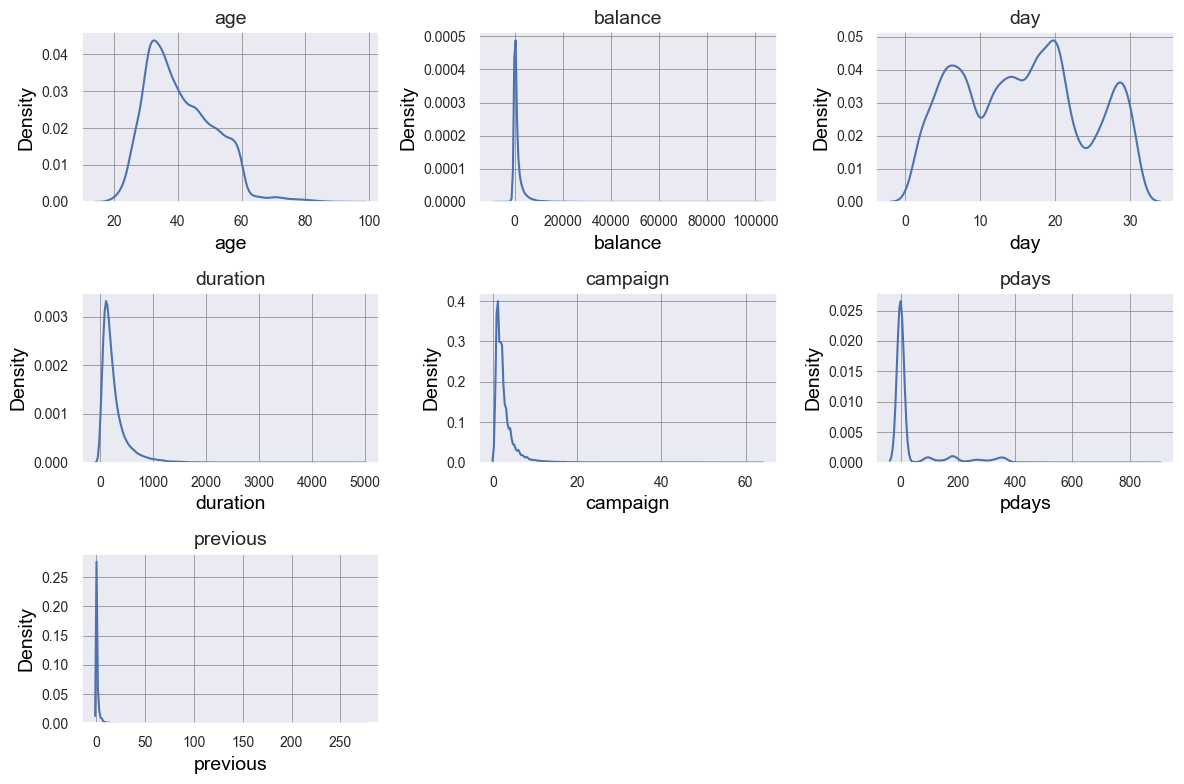

In [71]:
size_up(explore_num, 3, 'kde')

Some of the distributions are highly skewed, a power transform would be worth exploring

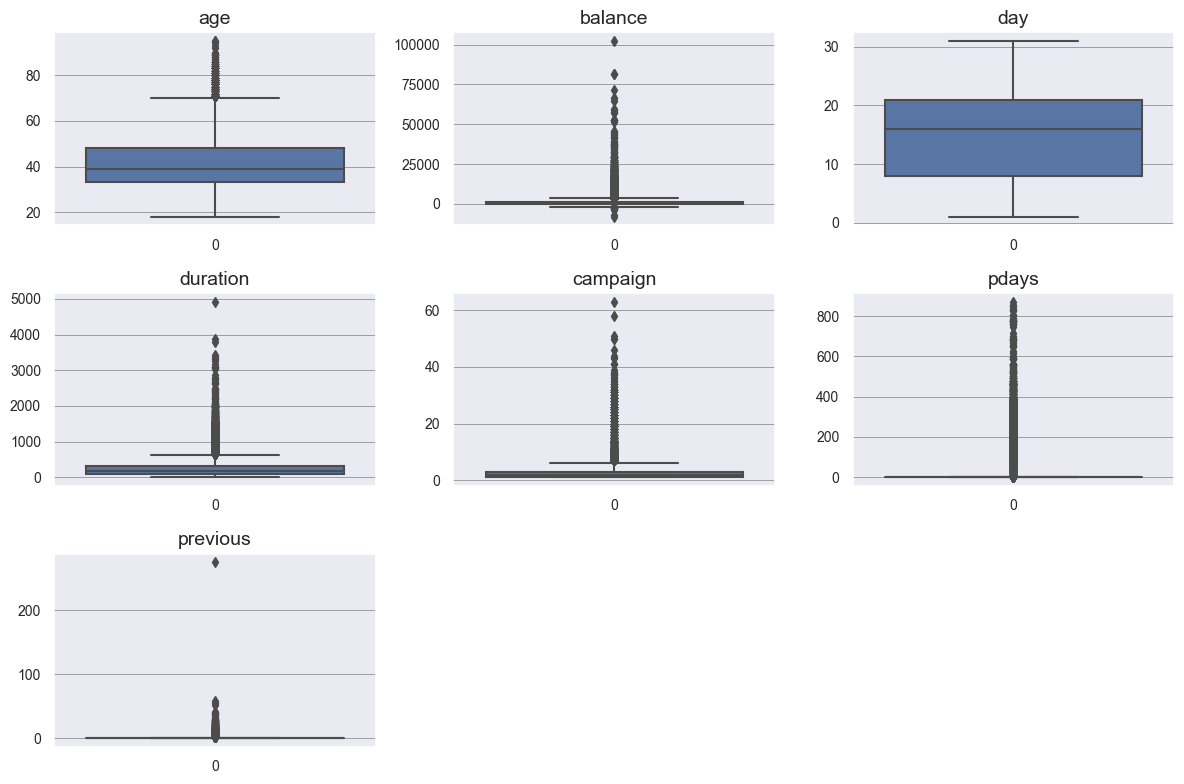

In [72]:
size_up(explore_num, 3, 'box')

Some of the numerical values have have outliers, we will deal with them later

How many people with job types have a credit default?

In [86]:
job_default = explore_df.groupby(['job','default']).agg({'age':['count','mean','min','max']})
job_default

age                   
                      count       mean min max
job           default                         
admin.        no       4078  39.230505  21  75
              yes        63  38.714286  25  59
blue-collar   no       7671  40.075609  20  75
              yes       159  37.264151  21  56
entrepreneur  no       1141  42.068361  21  84
              yes        45  43.288889  25  60
housemaid     no        996  46.325301  22  83
              yes        17  40.235294  26  59
management    no       7389  40.426309  21  80
              yes       122  40.901639  26  60
retired       no       1789  61.695920  24  95
              yes        23  56.652174  45  71
self-employed no       1218  40.553366  22  76
              yes        25  39.840000  26  57
services      no       3284  38.668088  20  69
              yes        64  36.953125  24  56
student       no        755  26.621192  18  48
              yes         3  25.333333  23  27
technician    no       5965  39.279464  21  71
              yes       103  37.514563  23  56
unemployed    no       1003  40.916251  21  65
              yes        21  38.571429  24  55
unknown       no        232  47.737069  25  82
              yes         2  48.500000  42  55

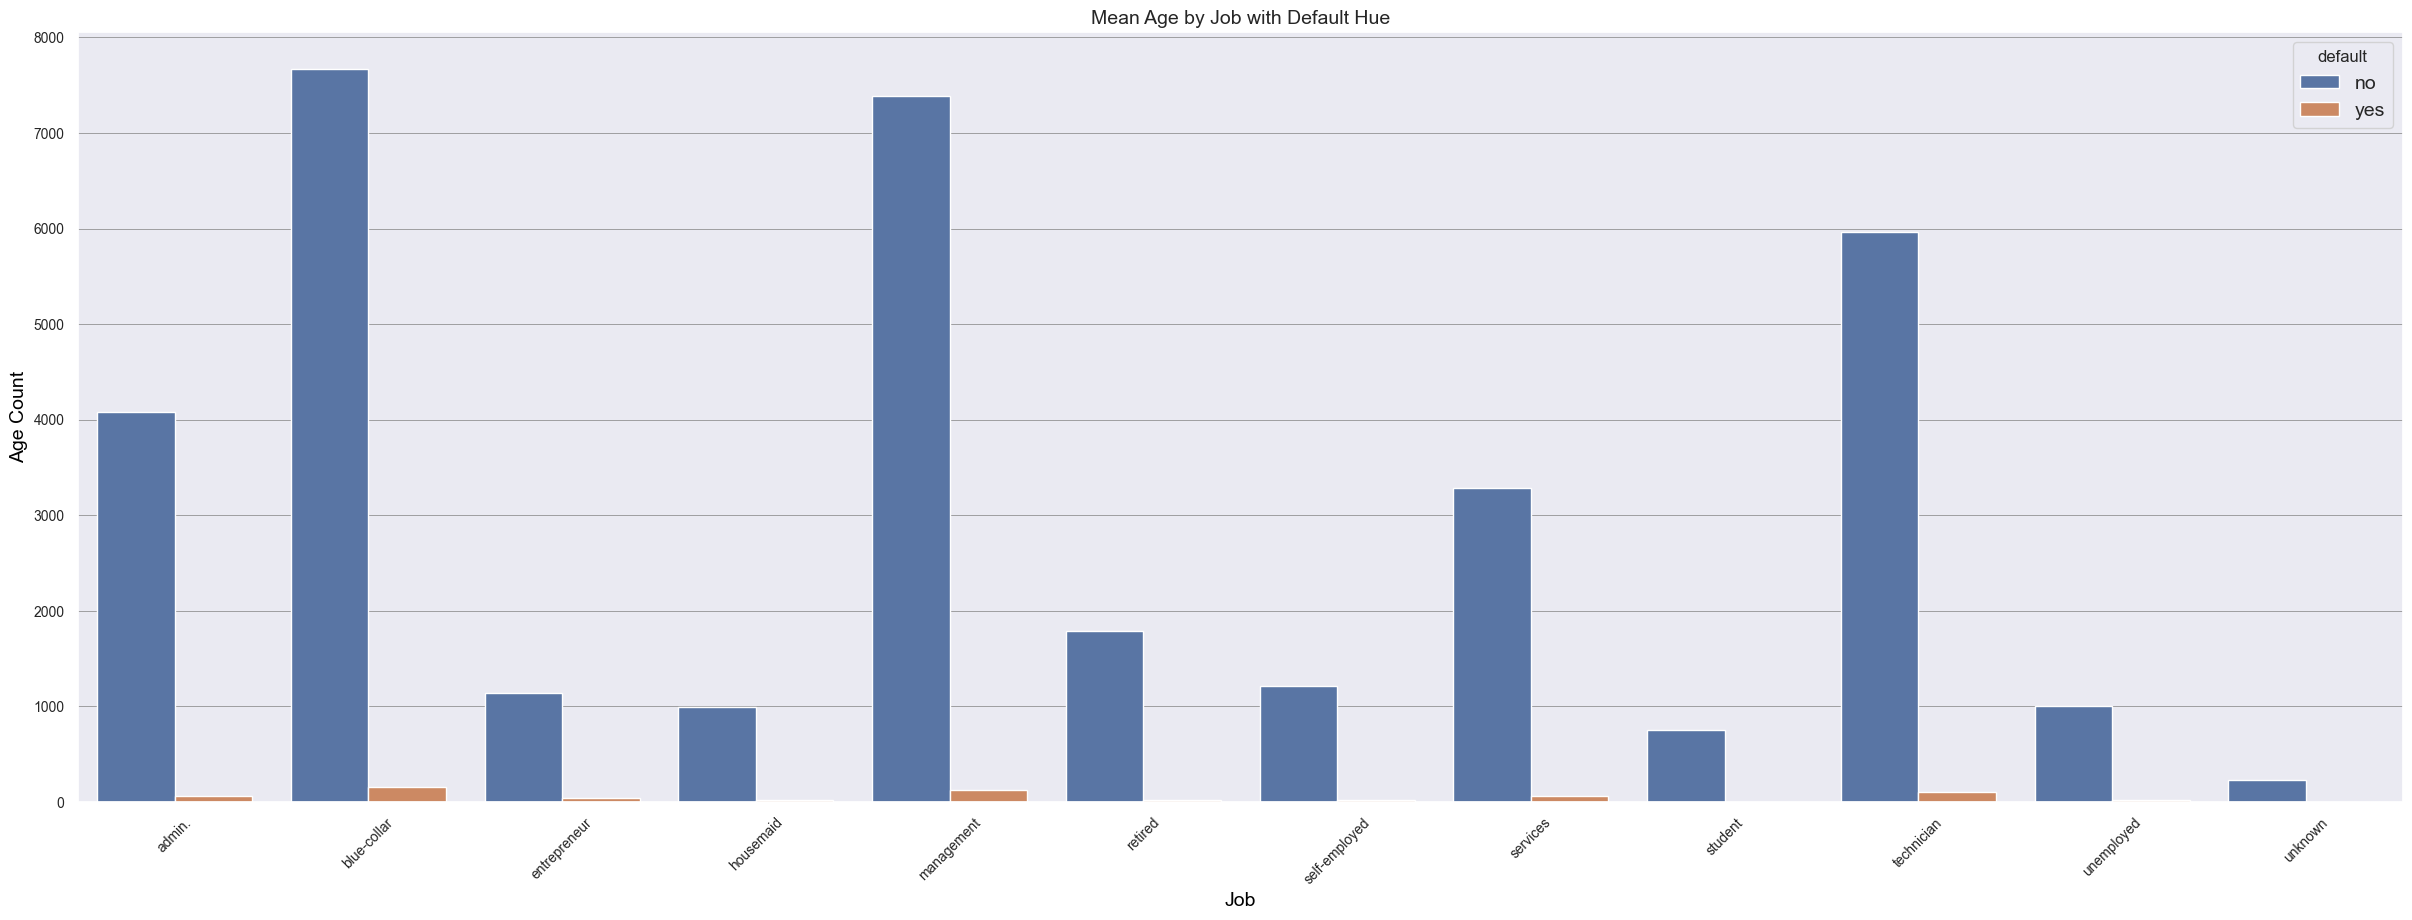

In [141]:
sns.barplot(data=job_default.reset_index(), x='job', y=('age', 'count'), hue='default')
plt.xlabel('Job')
plt.ylabel('Age Count')
plt.title('Mean Age by Job with Default Hue')
plt.xticks(rotation=45)
plt.show()

People with blue collar jobs defaulted even more than unemployed people

In [98]:
personal_loan = bank_df.groupby(['job','loan']).agg({'age':['count','mean']})

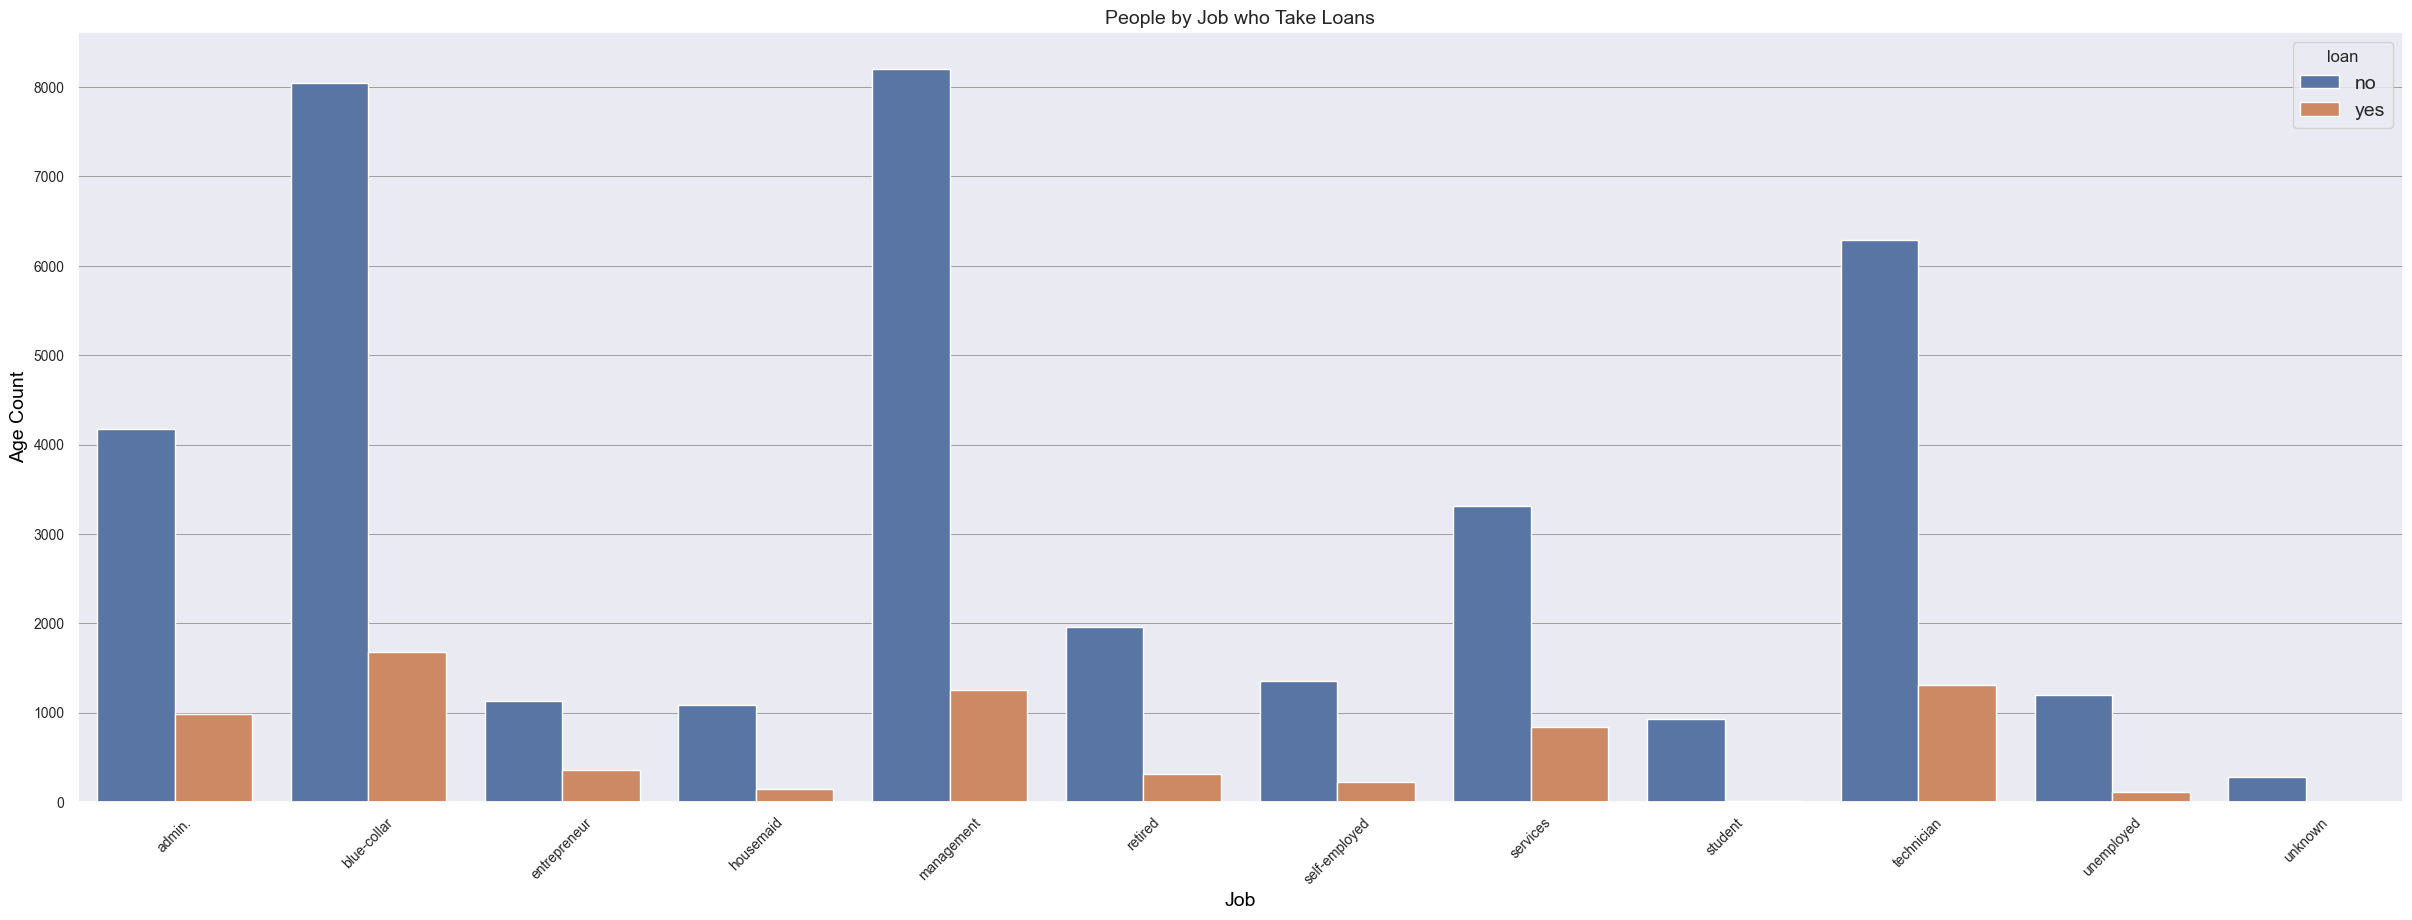

In [140]:
sns.barplot(data=personal_loan.reset_index(), x='job', y=('age', 'count'), hue='loan')
plt.xlabel('Job')
plt.ylabel('Age Count')
plt.title('People by Job who Take Loans')
plt.xticks(rotation=45)
plt.show()

In [ ]:
sns.histplot(data, kde=True, stat="density")
plt.xlabel('Variable')
plt.ylabel('Density')
plt.title('Frequency Polygon')
plt.show()

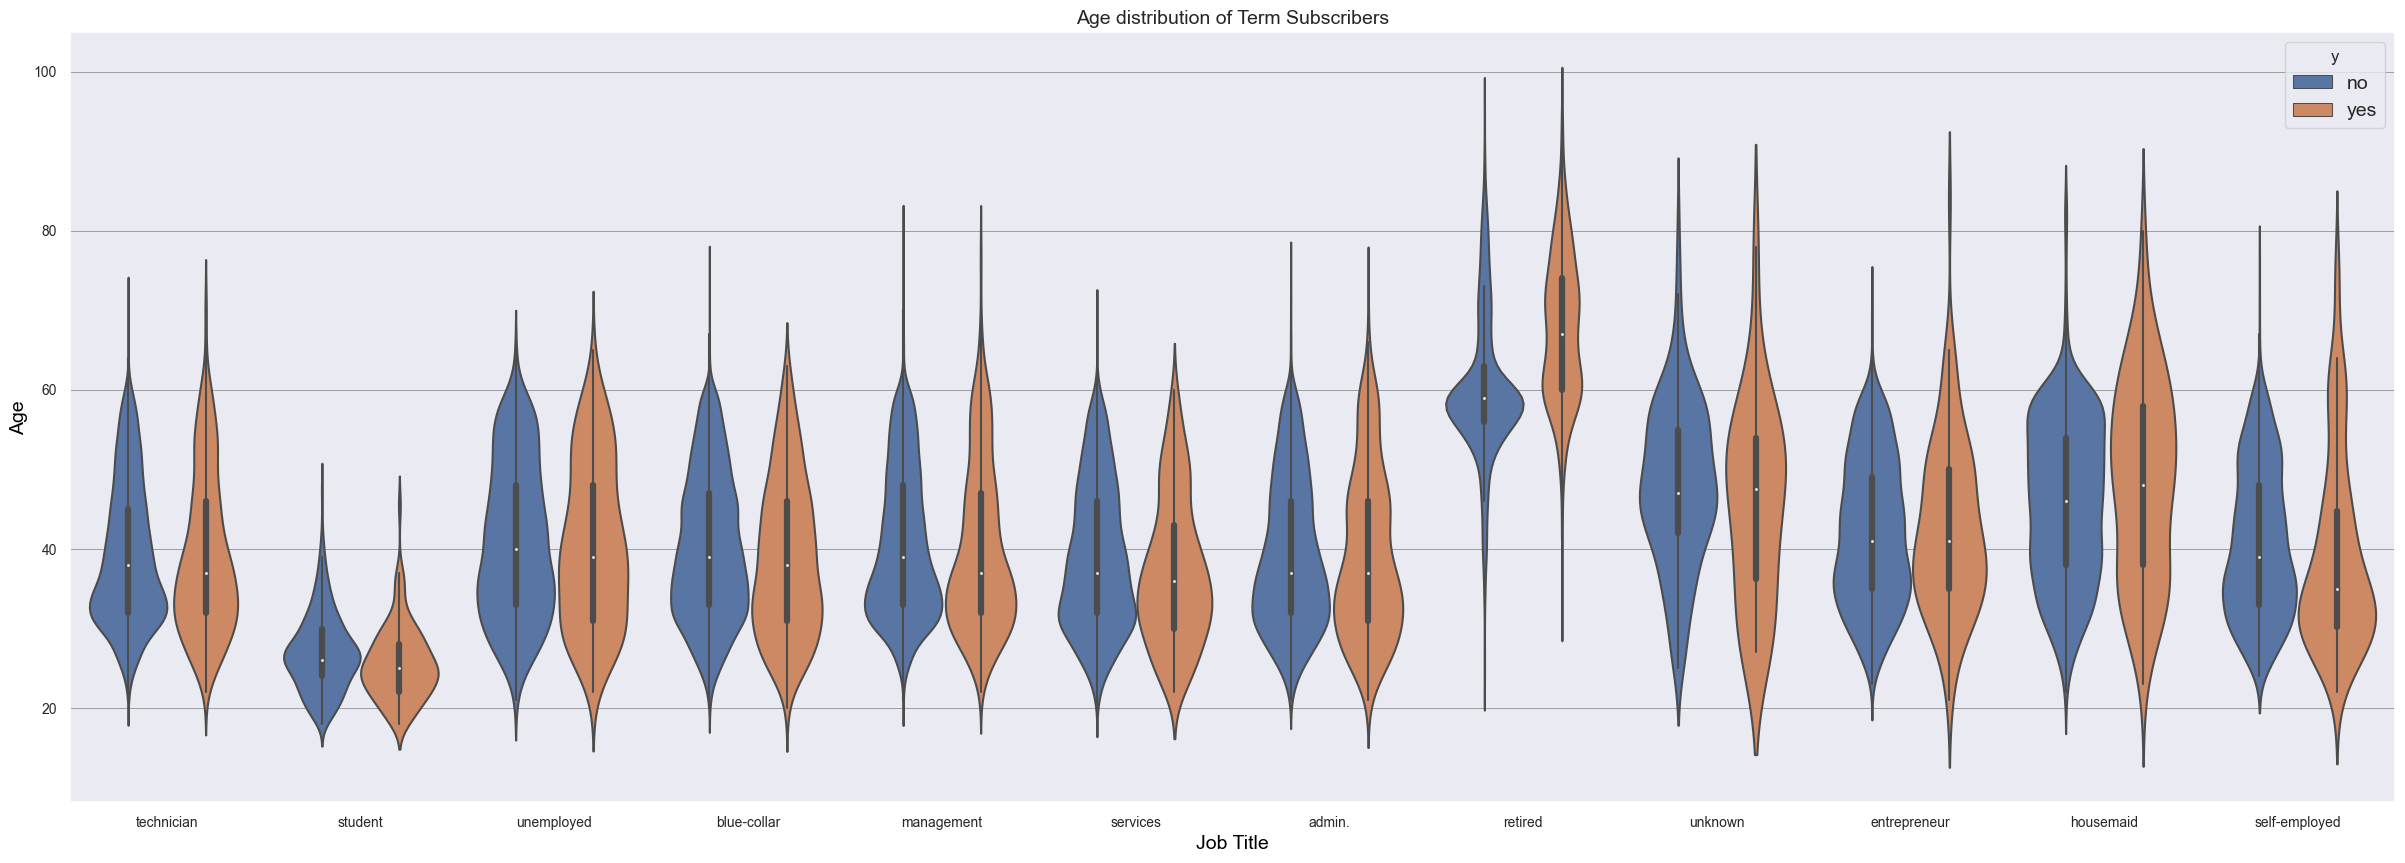

In [106]:
sns.violinplot(x="job", y="age", hue="y", data=explore_df)
plt.xlabel("Job Title")
plt.ylabel("Age")
plt.title("Age distribution of Term Subscribers")
plt.show()

More self-employed people aged about 25-35 subsribed to the term deposit

### Now we want to see the age category that are likely to say yes to a term deposit
We do binning on the age feature for this

In [110]:
explore_df["age_cat"] = pd.cut(explore_df["age"],
                               bins=[18, 35, 65, 95],
                               labels=['youthful', 'adult', 'senior'])

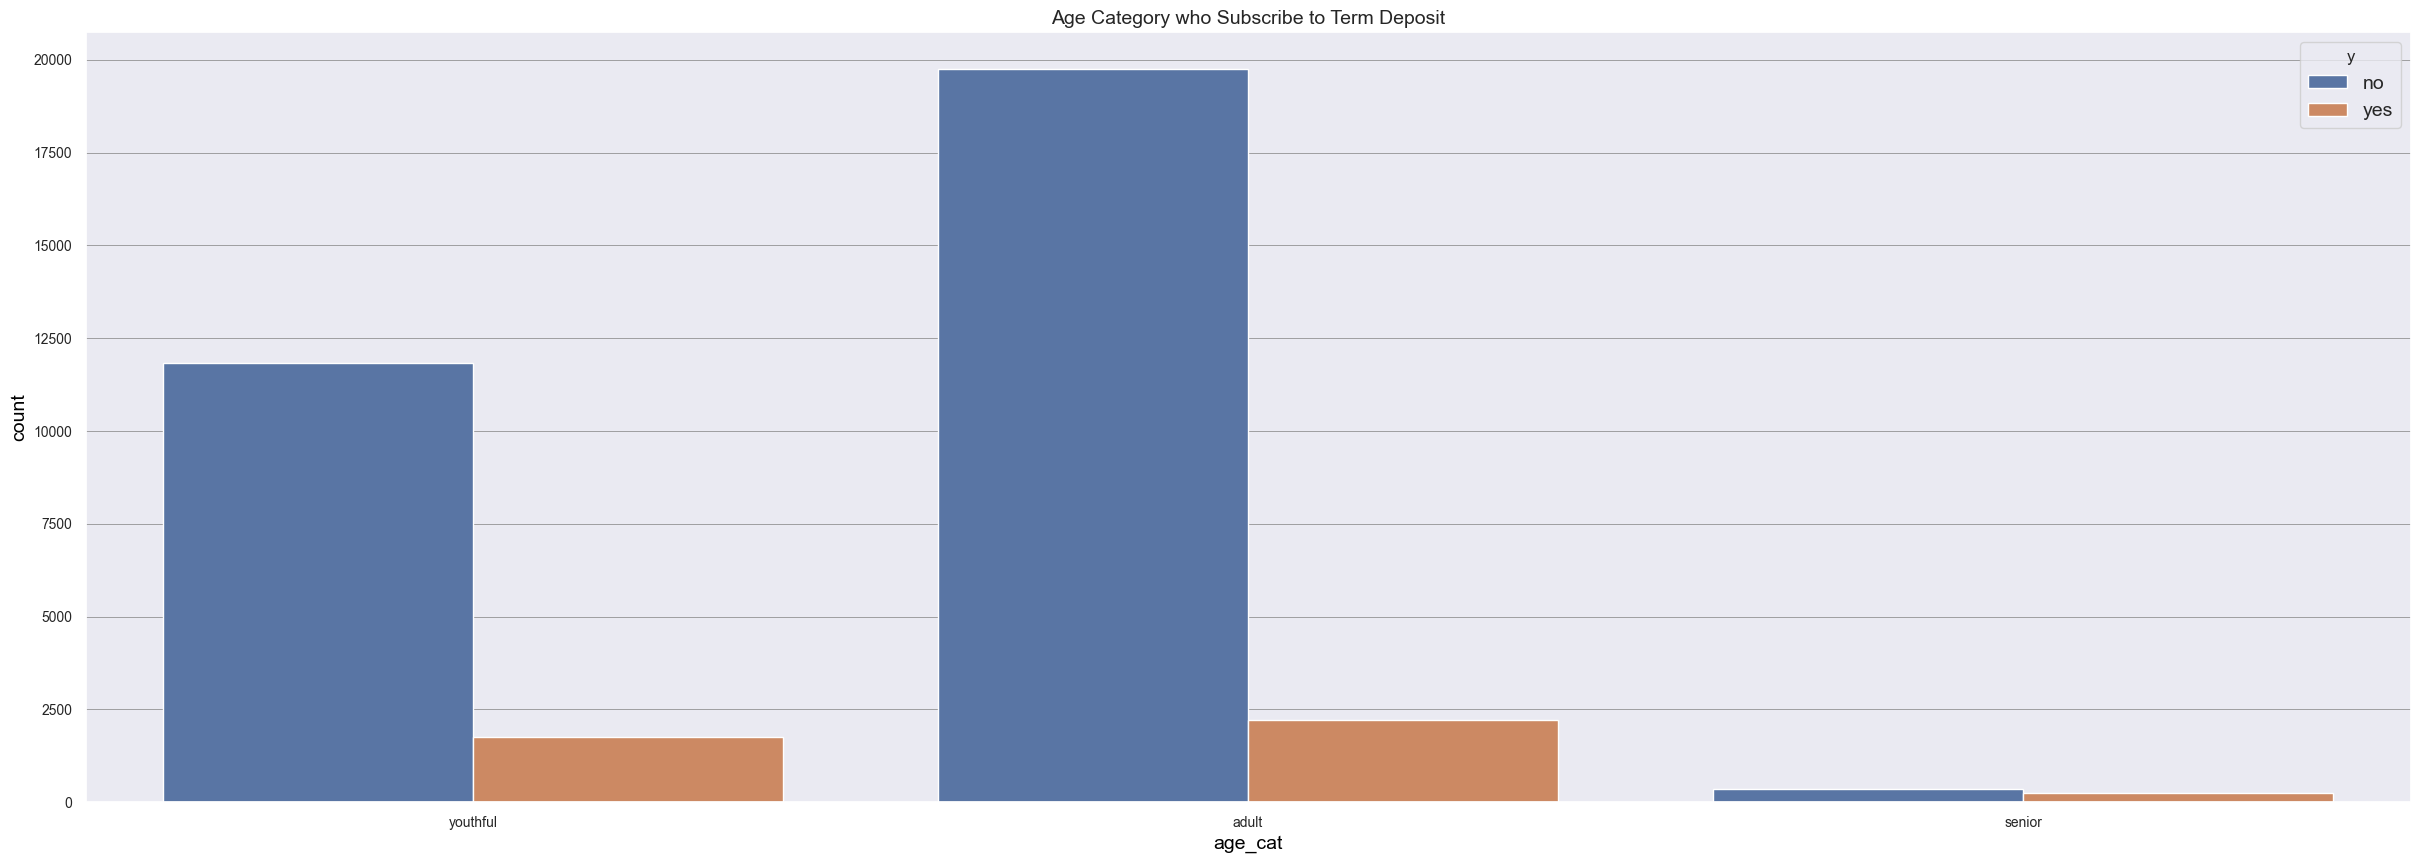

In [118]:
sns.countplot(data=explore_df, x='age_cat', hue='y')
plt.title("Age Category who Subscribe to Term Deposit")
plt.show()

In [119]:
explore_df.drop(columns='age_cat', axis=1, inplace=True)

### Let's Deal with Categorical Variables

In [121]:
explore_cat.dtypes

job          object
marital      object
education    object
default      object
housing      object
loan         object
contact      object
month        object
poutcome     object
y            object
dtype: object

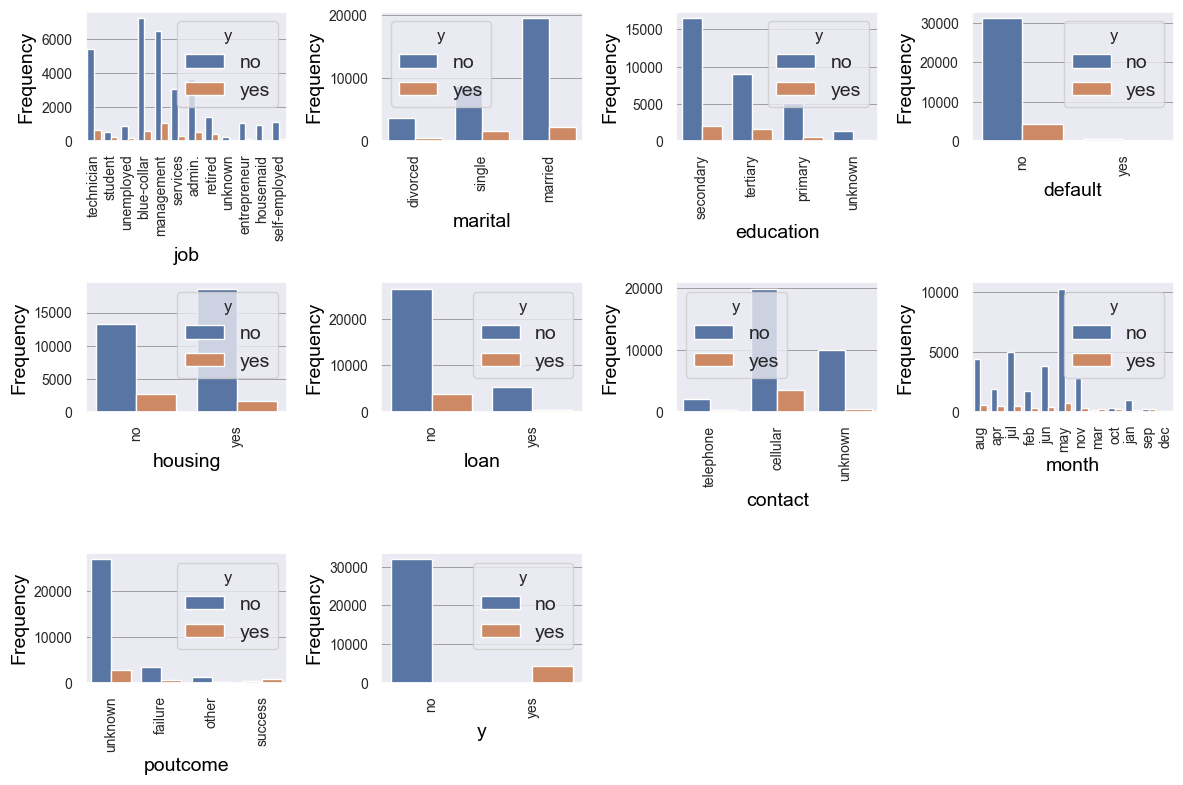

In [139]:
# Create a grid of subplots
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
axes = axes.flatten()

# Iterate over each numerical column and plot the histogram
for i, column in enumerate(explore_cat.columns):
  sns.countplot(data=explore_cat, x=f'{column}', hue='y', ax=axes[i])
  # sns.histplot(explore_num[column], ax=axes[i], kde=True, stat="density")  # default stat value is 'count'
  # axes[i].set_title(column)
  axes[i].set_xlabel(f'{column}')
  axes[i].set_ylabel('Frequency')
  axes[i].tick_params(axis='x', rotation=90)
  
# Remove any unused subplots
for ax in axes:
  if not ax.has_data():
    fig.delaxes(ax)

# Adjust the layout and display the plot
plt.tight_layout()
# plt.xticks(rotation=45)
plt.show()

It appears people in management subsribed more to the term deposit

In [143]:
# Assuming 'categorical_var1' and 'categorical_var2' are categorical variable columns and 'label' is the categorical label column
cross_tab = pd.crosstab([explore_df['job'], explore_df['loan']], explore_df['y'])
display(cross_tab)

y                     no  yes
job           loan           
admin.        no    2919  443
              yes    713   66
blue-collar   no    5992  486
              yes   1267   85
entrepreneur  no     813   87
              yes    272   14
housemaid     no     812   83
              yes    116    2
management    no    5554  965
              yes    916   76
retired       no    1158  399
              yes    238   17
self-employed no     932  125
              yes    169   17
services      no    2393  253
              yes    657   45
student       no     529  219
              yes     10    0
technician    no    4424  597
              yes    981   66
unemployed    no     789  152
              yes     77    6
unknown       no     205   26
              yes      1    2

In [152]:
cross_tab1 = pd.crosstab(explore_df['default'], explore_df['y'])

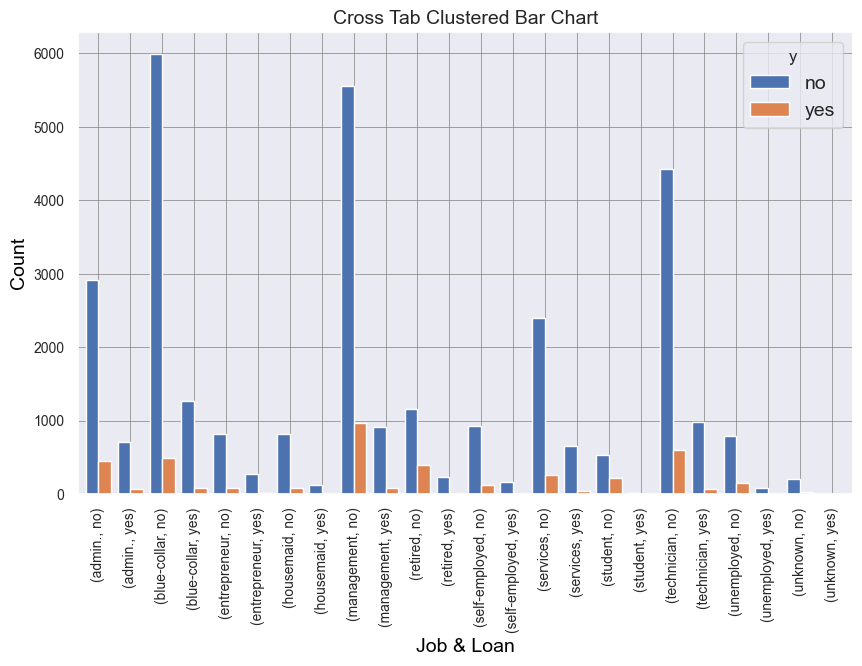

In [147]:
cross_tab.plot(kind='bar', figsize=(10, 6), width=0.8)
plt.xlabel('Job & Loan')
plt.ylabel('Count')
plt.title('Cross Tab Clustered Bar Chart')
plt.legend(title='y')
plt.show()

y,no,yes
default,,
no,31328,4193
yes,609,38


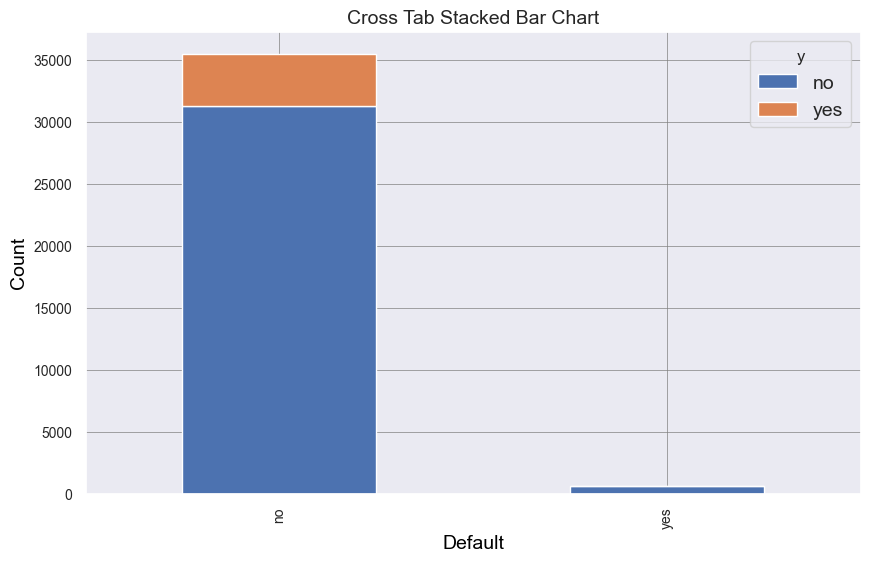

In [155]:
display(cross_tab1)
cross_tab1.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.xlabel('Default')
plt.ylabel('Count')
plt.title('Cross Tab Stacked Bar Chart')
plt.legend(title='y')
plt.show()

Very Few who have credit defaults said 'yes'. They probably didn't want any trouble!

## CHI-SQUARE TEST
The chi-square test can be applied to assess the independence between categorical variables and the categorical label. It helps determine if there is a statistically significant association between them. 

Interpretation: 
- If the p-value is less than the chosen significance level(0.05), we reject the null hypothesis and conclude that there is evidence of an association between the categorical variables. 
- If the p-value is greater than the significance level, we fail to reject the null hypothesis, indicating that there is insufficient evidence to conclude an association between the variables.

In [161]:
from scipy.stats import chi2_contingency
for i, col in enumerate(explore_cat.drop(columns='y', axis=1)):
  chi2, p, dof, expected = chi2_contingency(pd.crosstab(explore_cat[col], explore_cat['y']))
  print(f"Chi-square of {col}:", chi2)
  print(f"p-value of {col}:", p)

Chi-square of job: 686.9716929173353
p-value of job: 3.3453047561653717e-140
Chi-square of marital: 168.0021878089687
p-value of marital: 3.30208648314554e-37
Chi-square of education: 177.04083376631627
p-value of education: 3.841322927500452e-38
Chi-square of default: 21.068584141890756
p-value of default: 4.43134030981534e-06
Chi-square of housing: 702.2740627064891
p-value of housing: 9.576248624376933e-155
Chi-square of loan: 159.4995989499752
p-value of loan: 1.4553953289289066e-36
Chi-square of contact: 813.5186292973631
p-value of contact: 2.2216425534984927e-177
Chi-square of month: 2395.2053992184533
p-value of month: 0.0
Chi-square of poutcome: 3480.4530378942122
p-value of poutcome: 0.0


As all the p-values are less than 0.05 significance level, we reject the null-hypothesis 
and conclude that each of these categorical attributes have a significant relationship 
with the label

## Now we go back to train set
We want to do some preprocessing before we start spot checking some Algos

In [7]:
X_train = strat_train_set.drop(columns='y', axis=1)
y_train = strat_train_set.y

## Mark Missing Values
1. Mark all 'other' values in the poutcome attribute as NaN 
2. Mark all 'unknown' values in the contact attribute as NaN
3. Change all -1 in pdays to 0. This is because -1 means the 
customer had never been contacted before.

In [295]:
X_train.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
24001,36,technician,divorced,secondary,no,861,no,no,telephone,29,aug,140,2,-1,0,unknown
43409,24,student,single,secondary,no,4126,no,no,cellular,5,apr,907,4,185,7,failure
20669,44,technician,single,secondary,no,244,yes,no,cellular,12,aug,1735,4,-1,0,unknown
18810,48,unemployed,married,secondary,no,0,no,no,telephone,31,jul,35,11,-1,0,unknown
23130,38,technician,married,secondary,no,257,no,no,cellular,26,aug,57,10,-1,0,unknown


In [8]:
null_rows_idx = X_train.isnull().any(axis=1)

In [9]:
def mark_val_missing(df):
  df.loc[df['poutcome']=='other', 'poutcome'] = np.nan
  df.loc[df['contact']=='unknown', 'contact'] = np.nan
  df.loc[df['pdays']== -1, 'pdays'] = 0
  return df

In [10]:
def type_cast(df):
  num_df = df.select_dtypes(include=[np.number])
  cat_df = df.select_dtypes(exclude=[np.number])
  cat_df = cat_df.astype(str)
  df = pd.concat([cat_df, num_df], axis=1)
  return df

In [11]:
bank_df_marked = mark_val_missing(X_train)

In [12]:
bank_df_marked.isnull().any(axis=1).sum()

11848

In [13]:
bank_df_marked.isna().sum()

age              0
job              0
marital          0
education        0
default          0
balance          0
housing          0
loan             0
contact      10386
day              0
month            0
duration         0
campaign         0
pdays            0
previous         0
poutcome      1485
dtype: int64

## Imputation

In [14]:
mode_impute = SimpleImputer(strategy='most_frequent')
bank_df_to_impute = bank_df_marked.select_dtypes(exclude=[np.number])
bank_df_inputed = mode_impute.fit_transform(bank_df_to_impute)  # returns a ndarray

In [15]:
bank_df_to_impute

,job,marital,education,default,housing,loan,contact,month,poutcome
24001,technician,divorced,secondary,no,no,no,telephone,aug,unknown
43409,student,single,secondary,no,no,no,cellular,apr,failure
20669,technician,single,secondary,no,yes,no,cellular,aug,unknown
18810,unemployed,married,secondary,no,no,no,telephone,jul,unknown
23130,technician,married,secondary,no,no,no,cellular,aug,unknown
...,...,...,...,...,...,...,...,...,...
17958,blue-collar,married,secondary,no,yes,no,cellular,jul,unknown
15941,admin.,single,secondary,no,yes,no,cellular,jul,unknown
16952,blue-collar,married,secondary,no,yes,no,cellular,jul,unknown
34781,management,single,tertiary,no,yes,no,cellular,may,unknown


In [16]:
mode_impute.statistics_

array(['blue-collar', 'married', 'secondary', 'no', 'yes', 'no',
       'cellular', 'may', 'unknown'], dtype=object)

In [17]:
mode_impute.feature_names_in_

array(['job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'poutcome'], dtype=object)

In [19]:
bank_tr = pd.DataFrame(bank_df_inputed, columns=mode_impute.feature_names_in_,
                          index=bank_df_to_impute.index)

In [20]:
bank_tr.isnull().any(axis=1).sum()  # no more missing values

0

In [21]:
bank_tr[null_rows_idx]

,job,marital,education,default,housing,loan,contact,month,poutcome


## Type Cast

In [23]:
bank_tr = type_cast(bank_tr)

In [24]:
bank_num_df = bank_df_marked.select_dtypes(include=[np.number])
bank_num_df[null_rows_idx]

,age,balance,day,duration,campaign,pdays,previous


In [25]:
bank_df_filled = pd.concat([bank_tr, bank_num_df], axis=1)

In [27]:
bank_df_filled.head(7)

,job,marital,education,default,housing,loan,contact,month,poutcome,age,balance,day,duration,campaign,pdays,previous
24001,technician,divorced,secondary,no,no,no,telephone,aug,unknown,36,861,29,140,2,0,0
43409,student,single,secondary,no,no,no,cellular,apr,failure,24,4126,5,907,4,185,7
20669,technician,single,secondary,no,yes,no,cellular,aug,unknown,44,244,12,1735,4,0,0
18810,unemployed,married,secondary,no,no,no,telephone,jul,unknown,48,0,31,35,11,0,0
23130,technician,married,secondary,no,no,no,cellular,aug,unknown,38,257,26,57,10,0,0
15058,blue-collar,married,secondary,no,no,yes,cellular,jul,unknown,48,1513,17,1171,1,0,0
15908,management,married,tertiary,no,yes,no,cellular,jul,unknown,50,4315,22,181,11,0,0


## Encoding

In [28]:
ordinal_cols = ['month', 'poutcome']
one_hot_cols = ['job','education', 'default','marital', 
                'housing', 'loan','contact']              

In [29]:
ordinal_df = bank_df_filled[ordinal_cols]
one_hot_df = bank_df_filled[one_hot_cols]

In [30]:
months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun',
                                      'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
outcomes = ['success','unknown','failure']

# Assuming you have a DataFrame named 'data' with a 'month' column
# encoder = OrdinalEncoder(categories=[])
# data['month_encoded'] = encoder.fit_transform(data[['month']])

In [31]:
ord_enc = OrdinalEncoder(categories=[months,outcomes])
one_hot_enc = OneHotEncoder()

In [32]:
ordinal_df_encoded = ord_enc.fit_transform(ordinal_df)
one_hot_df_encoded = one_hot_enc.fit_transform(one_hot_df)

In [33]:
ordinal_df_encoded[:5]

array([[7., 1.],
       [3., 2.],
       [7., 1.],
       [6., 1.],
       [7., 1.]])

In [34]:
one_hot_df_encoded.toarray()

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 1., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.]])

In [35]:
ord_enc.categories_

[array(['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep',
        'oct', 'nov', 'dec'], dtype=object),
 array(['success', 'unknown', 'failure'], dtype=object)]

In [131]:
one_hot_enc.categories_

[array(['admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management',
        'retired', 'self-employed', 'services', 'student', 'technician',
        'unemployed', 'unknown'], dtype=object),
 array(['primary', 'secondary', 'tertiary', 'unknown'], dtype=object),
 array(['no', 'yes'], dtype=object),
 array(['divorced', 'married', 'single'], dtype=object),
 array(['no', 'yes'], dtype=object),
 array(['no', 'yes'], dtype=object),
 array(['cellular', 'telephone'], dtype=object)]

In [36]:
merged_encoded = np.concatenate((one_hot_df_encoded.toarray(), ordinal_df_encoded), axis=1)

In [37]:
merged_encoded

array([[0., 0., 0., ..., 1., 7., 1.],
       [0., 0., 0., ..., 0., 3., 2.],
       [0., 0., 0., ..., 0., 7., 1.],
       ...,
       [0., 1., 0., ..., 0., 6., 1.],
       [0., 0., 0., ..., 0., 4., 1.],
       [1., 0., 0., ..., 0., 6., 2.]])

In [38]:
enc_feature_names = one_hot_enc.get_feature_names_out().tolist()+ord_enc.get_feature_names_out().tolist()

In [39]:
encoded_df = pd.DataFrame(merged_encoded, columns=enc_feature_names,
                          index=X_train.index)

In [136]:
encoded_df.head()

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,education_primary,education_secondary,education_tertiary,education_unknown,default_no,default_yes,marital_divorced,marital_married,marital_single,housing_no,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,month,poutcome
24001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,7.0,1.0
43409,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,3.0,2.0
20669,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,7.0,1.0
18810,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,6.0,1.0
23130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,7.0,1.0


In [40]:
X_train_df = pd.concat([encoded_df, bank_num_df], axis=1)

In [41]:
X_train_df.head()

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,education_primary,education_secondary,education_tertiary,education_unknown,default_no,default_yes,marital_divorced,marital_married,marital_single,housing_no,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,month,poutcome,age,balance,day,duration,campaign,pdays,previous
24001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,7.0,1.0,36,861,29,140,2,0,0
43409,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,3.0,2.0,24,4126,5,907,4,185,7
20669,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,7.0,1.0,44,244,12,1735,4,0,0
18810,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,6.0,1.0,48,0,31,35,11,0,0
23130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,7.0,1.0,38,257,26,57,10,0,0


In [42]:
le = LabelEncoder()

In [43]:
label_encoded = le.fit_transform(y_train)

In [44]:
label_encoded

array([0, 1, 1, ..., 0, 0, 1])

In [45]:
le.classes_

array(['no', 'yes'], dtype=object)

In [46]:
X_train, y_train = X_train_df.values, label_encoded

## Spot Check Algorithms

In [159]:
models = [
    ('XGB', xgb.XGBClassifier()),
    ('LR', LogisticRegression()),
    ('LDA', LinearDiscriminantAnalysis()),
    ('KNN', KNeighborsClassifier()),
    ('CART', DecisionTreeClassifier()),
    ('NB', GaussianNB()),
    ('SVM', SVC()),
    ('RFC', RandomForestClassifier())
]


# evaluate each model in turn
results = []
names = []
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

for name, model in models:
  # n_scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
  # kfold = KFold(n_splits=10, random_state=seed, shuffle=True)
  scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
  results.append(scores)
  names.append(name)
  print(f'{name}: Mean Accuracy = {scores.mean():.4f}, Standard Deviation = {scores.std():.4f}')

XGB: Mean Accuracy = 0.9055, Standard Deviation = 0.0037


/Users/yawasante/anaconda3/envs/some_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yawasante/anaconda3/envs/some_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

LR: Mean Accuracy = 0.8903, Standard Deviation = 0.0033
LDA: Mean Accuracy = 0.8980, Standard Deviation = 0.0034
KNN: Mean Accuracy = 0.8820, Standard Deviation = 0.0034
CART: Mean Accuracy = 0.8721, Standard Deviation = 0.0030
NB: Mean Accuracy = 0.8260, Standard Deviation = 0.0066
SVM: Mean Accuracy = 0.8832, Standard Deviation = 0.0007
RFC: Mean Accuracy = 0.9031, Standard Deviation = 0.0034


Looks like the top 3 models that worked best on the preprocessed data are:
1. XGBoost
2. Random Forest Classifier
3. Linear Discriminant Analysis

This data is preprocessed, but we did not do much about the distributions of the features(as seen during EDA).

We have also not scaled the data as some of the units were different.

Here are some things to do and then try spot-checking again to see if there are improvements in the results above
1. Power transform
2. Scaling
3. Feature Engineering

## Outlier Detection

We will use two techniques to attempt to catch outliers in our data

In [76]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

In [165]:
isolation_forest = IsolationForest(random_state=42)
lof = LocalOutlierFactor()

lof_pred = lof.fit_predict(bank_num_df.values)
iso_pred = isolation_forest.fit_predict(bank_num_df.values)

In [168]:
print(lof_pred)
print(iso_pred)

[1 1 1 ... 1 1 1]
[ 1 -1 -1 ...  1  1 -1]


In [171]:
print(np.count_nonzero(lof_pred == -1))
print(np.count_nonzero(iso_pred == -1))

713
4816


The IsolationForest found more outliers than the LocalOutlierFactor

Since there are outliers in the continuous features, the transform we'll use is the `QuantileTransformer`
on the numeric features

We will also use Robust Scaling.

If you have time, you can try out other transforms and scaling to see the effect

In [176]:
X_train_df.head()

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,education_primary,education_secondary,education_tertiary,education_unknown,default_no,default_yes,marital_divorced,marital_married,marital_single,housing_no,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,month,poutcome,age,balance,day,duration,campaign,pdays,previous
24001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,7.0,1.0,36,861,29,140,2,0,0
43409,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,3.0,2.0,24,4126,5,907,4,185,7
20669,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,7.0,1.0,44,244,12,1735,4,0,0
18810,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,6.0,1.0,48,0,31,35,11,0,0
23130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,7.0,1.0,38,257,26,57,10,0,0


In [181]:
X_train_df.columns.tolist().index('age')

29

### Pipelines
Put put the further preprocessing steps into a pipeline

In [191]:
columns_to_trans = X_train_df.select_dtypes(include=['int64']).columns
preprocessing = ColumnTransformer(
    transformers=[
        ('quantile_transform', QuantileTransformer(n_quantiles=100, output_distribution='normal'), columns_to_trans),
        ('scaling', RobustScaler(), columns_to_trans)
    ],
    remainder='passthrough'
)

# Define the classification models to test
classifiers = [
    ('XGB', xgb.XGBClassifier()),
    ('LR', LogisticRegression()),
    ('LDA', LinearDiscriminantAnalysis()),
    ('KNN', KNeighborsClassifier()),
    ('CART', DecisionTreeClassifier()),
    ('NB', GaussianNB()),
    ('SVM', SVC()),
    ('RFC', RandomForestClassifier())
]

# Perform cross-validation 
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
for name, classifier in classifiers:
    pipeline = Pipeline([
        ('preprocessing', preprocessing),
        ('poly_features_eng', PolynomialFeatures(degree=2)),
        ('classif', classifier)
    ])
    
    scores = cross_val_score(pipeline, X_train_df, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
    print(f'{name}: Mean Accuracy = {scores.mean():.4f}, Standard Deviation = {scores.std():.4f}')

XGB: Mean Accuracy = 0.9048, Standard Deviation = 0.0043


/Users/yawasante/anaconda3/envs/some_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yawasante/anaconda3/envs/some_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

LR: Mean Accuracy = 0.8925, Standard Deviation = 0.0027
LDA: Mean Accuracy = 0.8989, Standard Deviation = 0.0042
KNN: Mean Accuracy = 0.8921, Standard Deviation = 0.0037
CART: Mean Accuracy = 0.8669, Standard Deviation = 0.0053
NB: Mean Accuracy = 0.8215, Standard Deviation = 0.0063
SVM: Mean Accuracy = 0.8829, Standard Deviation = 0.0008
RFC: Mean Accuracy = 0.9031, Standard Deviation = 0.0042


We can see that some of the models got better, while others got worse!

### Feature Selection
The polynomial feature engineering brought a huge dimensionality to our data.

Thus, we'd like so select some features. Another thing we could do is apply
dimensionality reduction.

We will use Principal Component Analysis to attempt some dimensionality reduction.

In [52]:
from sklearn.decomposition import PCA

In [57]:
models = [LinearDiscriminantAnalysis(), xgb.XGBClassifier(), RandomForestClassifier()]

# evaluate the models and store results
results, names = list(), list()
for name, model in enumerate(models):
  pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('poly_features_eng', PolynomialFeatures(degree=2)),
    ('pca', PCA(n_components=25)),
    ('classif', model)
    ])
  scores = evaluate_model(pipeline, X_train_df, y_train)
  results.append(scores)
  names.append(name)
  print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
  
# plot model performance for comparison
# plt.boxplot(results, labels=names, showmeans=True)
# plt.show()

>0 0.888 (0.002)
>1 0.898 (0.004)
>2 0.900 (0.004)


### Grid Search
We perform a grid search to also find the optimal number of components
for the dimensionality reduction of<br>
our three models (XGBoost, RandomForestClassifier and Linear Discriminant Analysis)

In [64]:
best_three = [
    ('XGB', xgb.XGBClassifier()),
    ('LDA', LinearDiscriminantAnalysis()),
    ('RFC', RandomForestClassifier())
]

# Define the range of feature numbers to consider
feature_numbers = range(20, 101, 5)

param_grid = {
    'dim_reduction__n_components': feature_numbers
}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
for name, classifier in best_three:
  pipeline = Pipeline([
      ('preprocessing', preprocessing),
      ('poly_features_eng', PolynomialFeatures(degree=2)),
      ('dim_reduction', PCA(n_components=25)),
      ('classif', classifier)
  ])
  grid_search = GridSearchCV(pipeline, param_grid, scoring='accuracy', cv=5)

  grid_search.fit(X_train_df, y_train)  # X is your feature matrix, y is the target variable

  # Get the best number of features:
  best_features = grid_search.best_params_['dim_reduction__n_components']
  print(name)
  print("Best number of features:", best_features)

  # Evaluate the performance of the best feature subset:
  best_model = grid_search.best_estimator_
  scores = cross_val_score(best_model, X_train_df, y_train, cv=cv, scoring='accuracy', n_jobs=-1)  # Evaluate using cross-validation
  print("Cross-validation scores:", scores)
  print("Mean score:", scores.mean())

  # Perform cross-validation 

  
  
  # scores = cross_val_score(pipeline, X_train_df, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
  # print(f'{name}: Mean Accuracy = {scores.mean():.4f}, Standard Deviation = {scores.std():.4f}')

XGB
Best number of features: 55
Cross-validation scores: [0.90129942 0.90572297 0.89936411 0.89936411 0.89576998 0.90517003
 0.90157589 0.89659939 0.90486726 0.89878319 0.90599945 0.90323472
 0.90378767 0.89604645 0.89798175 0.90185236 0.8985347  0.8954935
 0.89767699 0.8965708  0.90240531 0.89079348 0.89742881 0.89936411
 0.90074647 0.90074647 0.8935582  0.89687586 0.90403761 0.89740044]
Mean score: 0.8996350505601621
LDA
Best number of features: 80
Cross-validation scores: [0.89881117 0.90129942 0.89162289 0.89521703 0.89521703 0.8954935
 0.90157589 0.89466409 0.90182522 0.89850664 0.9035112  0.90240531
 0.89715234 0.89687586 0.89908764 0.90102295 0.89881117 0.88996406
 0.88993363 0.89740044 0.89659939 0.89245231 0.89908764 0.90517003
 0.90074647 0.89438761 0.89604645 0.88802875 0.90099558 0.90210177]
Mean score: 0.8975337827230148
RFC
Best number of features: 65
Cross-validation scores: [0.89964059 0.90489356 0.90517003 0.89881117 0.90074647 0.90074647
 0.90047    0.89162289 0.90763

## Final Model
The RandomForestClassifier will be chosen as the best model going forward.

We would like to tune some hyperparameters in an attempt to maximize the predictive skill
of the model

### Hyperparameter Tuning

In [73]:
# Define the columns to transform
columns_to_trans = X_train_df.select_dtypes(include=['int64']).columns

# Define the preprocessing steps
preprocessing = ColumnTransformer(
    transformers=[
        ('quantile_transform', QuantileTransformer(n_quantiles=100, output_distribution='normal'), columns_to_trans),
        ('scaling', RobustScaler(), columns_to_trans)
    ],
    remainder='passthrough'
)

# Create the pipeline
pipeline = Pipeline([
      ('preprocessing', preprocessing),
      ('poly_features_eng', PolynomialFeatures(degree=2)),
      ('dim_reduction', PCA(n_components=65)),
      ('classif', RandomForestClassifier())
])

# Define the hyperparameters to tune
param_grid = {
    'classif__n_estimators': [100, 200, 300],
    'classif__max_depth': [None, 5, 10],
    'classif__min_samples_split': [2, 5, 10]
}

# Perform grid search
grid_search = GridSearchCV(pipeline, param_grid, scoring='accuracy', cv=5)
grid_search.fit(X_train_df, y_train)

# Print the best hyperparameters and score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Hyperparameters: {'classif__max_depth': None, 'classif__min_samples_split': 10, 'classif__n_estimators': 200}
Best Score: 0.9019575708225451


## Final Pipeline
Build a final pipeline to fit on full training set

In [88]:
X_train = strat_train_set.drop(columns='y', axis=1)
y_train = strat_train_set.y

In [80]:
def mark_val_missing(df):
  df.loc[df['poutcome']=='other', 'poutcome'] = np.nan
  df.loc[df['contact']=='unknown', 'contact'] = np.nan
  df.loc[df['pdays']== -1, 'pdays'] = 0
  return df

def impute(df):
  mode_impute = SimpleImputer(strategy='most_frequent')
  bank_df_to_impute = df.select_dtypes(exclude=[np.number])
  num_df = df.select_dtypes(include=[np.number])
  bank_df_inputed = mode_impute.fit_transform(bank_df_to_impute)  
  bank_tr = pd.DataFrame(bank_df_inputed, columns=mode_impute.feature_names_in_,
                          index=bank_df_to_impute.index)
  df = pd.concat([bank_tr, num_df], axis=1)
  return df
  
def type_cast(df):
  num_df = df.select_dtypes(include=[np.number])
  cat_df = df.select_dtypes(exclude=[np.number])
  cat_df = cat_df.astype(str)
  df = pd.concat([cat_df, num_df], axis=1)
  return df

def encoder(df):
  ordinal_cols = ['month', 'poutcome']
  one_hot_cols = ['job','education', 'default','marital', 
                'housing', 'loan','contact'] 
  ordinal_df = df[ordinal_cols]
  one_hot_df = df[one_hot_cols]
  
  months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun',
                                      'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
  outcomes = ['success','unknown','failure']
  
  ord_enc = OrdinalEncoder(categories=[months,outcomes])
  one_hot_enc = OneHotEncoder()
  ordinal_df_encoded = ord_enc.fit_transform(ordinal_df)
  one_hot_df_encoded = one_hot_enc.fit_transform(one_hot_df)
  
  merged_encoded = np.concatenate((one_hot_df_encoded.toarray(), ordinal_df_encoded), axis=1)
  enc_feature_names = one_hot_enc.get_feature_names_out().tolist() + \
    ord_enc.get_feature_names_out().tolist()
  encoded_df = pd.DataFrame(merged_encoded, columns=enc_feature_names,
                          index=df.index)
  df_num = df.select_dtypes(include=[np.number])
  
  df = pd.concat([encoded_df, df_num], axis=1)
  
  return df

In [84]:
# Define the FunctionTransformer for each preprocessing function
mark_val_missing_transformer = FunctionTransformer(mark_val_missing)
impute_transformer = FunctionTransformer(impute)
type_cast_transformer = FunctionTransformer(type_cast)
encoder_transformer = FunctionTransformer(encoder)

# Create the pipeline
preprocessing_pipeline = Pipeline([
    ('mark_val_missing', mark_val_missing_transformer),
    ('impute', impute_transformer),
    ('type_cast', type_cast_transformer),
    ('encoder', encoder_transformer)
])

# Apply the preprocessing pipeline to the training data
X_train_processed = preprocessing_pipeline.fit_transform(X_train)

### Full Pipeline

In [95]:
# Define the FunctionTransformer for each preprocessing function
mark_val_missing_transformer = FunctionTransformer(mark_val_missing)
impute_transformer = FunctionTransformer(impute)
type_cast_transformer = FunctionTransformer(type_cast)
encoder_transformer = FunctionTransformer(encoder)

# Create the preprocessing pipeline
preprocessing_pipeline = Pipeline([
    ('mark_val_missing', mark_val_missing_transformer),
    ('impute', impute_transformer),
    ('type_cast', type_cast_transformer),
    ('encoder', encoder_transformer)
])


# encode label
preprocessing_target = LabelEncoder()
y_train = preprocessing_target.fit_transform(y_train)

# Define the ColumnTransformer for other preprocessing steps
preprocessing = ColumnTransformer(
    transformers=[
        ('quantile_transform', QuantileTransformer(n_quantiles=100, output_distribution='normal'), columns_to_trans),
        ('scaling', RobustScaler(), columns_to_trans)
    ],
    remainder='passthrough'
)

# Create the full pipeline
further_preprocessing_pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('poly_features_eng', PolynomialFeatures(degree=2)),
    ('dim_reduction', PCA(n_components=65)),
    ('classif', RandomForestClassifier(max_depth=None, min_samples_split=10, n_estimators=200))
])

full_pipeline = make_pipeline(
    preprocessing_pipeline,
    further_preprocessing_pipeline
)

### Training

In [96]:
# Fit the full pipeline on the preprocessed training data
full_pipeline.fit(X_train, y_train)

Pipeline(steps=[('pipeline-1',
                 Pipeline(steps=[('mark_val_missing',
                                  FunctionTransformer(func=<function mark_val_missing at 0x28b749a80>)),
                                 ('impute',
                                  FunctionTransformer(func=<function impute at 0x28b749080>)),
                                 ('type_cast',
                                  FunctionTransformer(func=<function type_cast at 0x28b749300>)),
                                 ('encoder',
                                  FunctionTransformer(func=<function encoder at 0x28b74a7a0>))])),
                ('pip...
                                                                   Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'], dtype='object')),
                                                                  ('scaling',
                                                                   RobustScaler(),
                                                                   Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'], dtype='object'))])),
                                 ('poly_features_eng', PolynomialFeatures()),
                                 ('dim_reduction', PCA(n_components=65)),
                                 ('classif',
                                  RandomForestClassifier(min_samples_split=10,
                                                         n_estimators=200))]))])

### Test Model 

In [97]:
X_test = strat_test_set.drop(columns='y', axis=1)
y_test = strat_test_set.y

In [98]:
y_pred = full_pipeline.predict(X_test)

In [99]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [100]:
y_hat = preprocessing_target.inverse_transform(y_pred)

In [103]:
y_hat

array(['no', 'no', 'no', ..., 'no', 'no', 'no'], dtype=object)

### Error Metrics

In [104]:
from sklearn.metrics import accuracy_score

# Assuming you have inverse transformed y_pred to y_pred_inverse

# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_hat)

# Print the accuracy score
print("Accuracy:", accuracy)

Accuracy: 0.900364923144974
